<a href="https://colab.research.google.com/github/AniLeo-01/Plastic-In-River-Detection/blob/main/notebooks/Plastic_In_River_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Plastic In River dataset

In [ ]:
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset('Kili/plastic_in_river', num_proc=6)
print(dataset)
print(dataset['train'][0])

Setting num_proc from 6 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split:   0%|          | 0/3407 [00:00<?, ? examples/s]

Setting num_proc from 6 back to 1 for the test split to disable multiprocessing as it only contains one shard.


Generating test split:   0%|          | 0/427 [00:00<?, ? examples/s]

Setting num_proc from 6 back to 1 for the validation split to disable multiprocessing as it only contains one shard.


Generating validation split:   0%|          | 0/425 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'litter'],
        num_rows: 3407
    })
    test: Dataset({
        features: ['image', 'litter'],
        num_rows: 427
    })
    validation: Dataset({
        features: ['image', 'litter'],
        num_rows: 425
    })
})
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7A3B7C1B7400>, 'litter': {'label': [2, 2], 'bbox': [[0.6937950849533081, 0.17073695361614227, 0.017922647297382355, 0.011738809756934643], [0.5574886202812195, 0.18079878389835358, 0.021695835515856743, 0.010061836801469326]]}}


YOLO Dataset Format:
```
datasets/
  -images
    - train
      - 0.png
      - 1.png
      - *.png
    - validation
  -labels
    - train
      - 0.txt
      - 1.txt
      - *.txt
    - validation

```

Format for labels:

0.txt

```
0 x_n y_n w_n h_n
1 x_n y_n w_n h_n
```


## Creating the dataset

In [ ]:
import os
from tqdm.notebook import tqdm

os.makedirs('datasets/images/train', exist_ok=True)
os.makedirs('datasets/images/validation', exist_ok=True)
os.makedirs('datasets/labels/train', exist_ok=True)
os.makedirs('datasets/labels/validation', exist_ok=True)

def create_dataset(data, split):
  data = data[split]
  print(f'Running for {split} split...')
  for idx, sample in tqdm(enumerate(data), total=len(data)):
    image = sample['image']
    labels = sample['litter']['label']
    bboxes = sample['litter']['bbox']
    targets = []
    # creating the label txt files
    for label, bbox in zip(labels, bboxes):
      targets.append(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}')
    with open(f'datasets/labels/{split}/{idx}.txt', 'w') as f:
      for target in targets:
        f.write(target+'\n')
    image.save(f'datasets/images/{split}/{idx}.png')

create_dataset(dataset, 'train')
create_dataset(dataset, 'validation')


  0%|          | 0/3407 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

# Training pipeline


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')

model.train(
    data = 'plastic.yaml',
    epochs = 20,
    imgsz = (1280, 720), #(w, h)
    batch = 4,
    optimizer = 'Adam',
    lr0 = 1e-3,
    resume=True
)


100%|██████████| 49.7M/49.7M [00:00<00:00, 95.0MB/s]
Ultralytics YOLOv8.0.147 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=plastic.yaml, epochs=20, patience=50, batch=4, imgsz=(1280, 720), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=

# Prediction Pipeline

In [ ]:
from ultralytics import YOLO
from PIL import Image

img = dataset['test'][20]['image']

#choosing the best training checkpoint
model = YOLO('runs/detect/train/weights/best.pt')

pred = model.predict(img)[0]
print(pred.boxes)

#plotting the image with bounding boxes
pred = pred.plot(line_width=1)
#convert from BGR to RGB
pred_rgb = pred[..., ::-1]
pred_img = Image.fromarray(pred_rgb)

pred_img.save('output.png')



0: 640x1280 1 PLASTIC_BOTTLE, 78.2ms
Speed: 9.5ms preprocess, 78.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1280)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([[9.1735e+02, 3.8762e+02, 1.0262e+03, 4.2039e+02, 7.8100e-01, 1.0000e+00]], device='cuda:0')
cls: tensor([1.], device='cuda:0')
conf: tensor([0.7810], device='cuda:0')
data: tensor([[9.1735e+02, 3.8762e+02, 1.0262e+03, 4.2039e+02, 7.8100e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[971.7907, 404.0042, 108.8746,  32.7650]], device='cuda:0')
xywhn: tensor([[0.7592, 0.6313, 0.0851, 0.0512]], device='cuda:0')
xyxy: tensor([[ 917.3534,  387.6217, 1026.2280,  420.3867]], device='cuda:0')
xyxyn: tensor([[0.7167, 0.6057, 0.8017, 0.6569]], device='cuda:0')


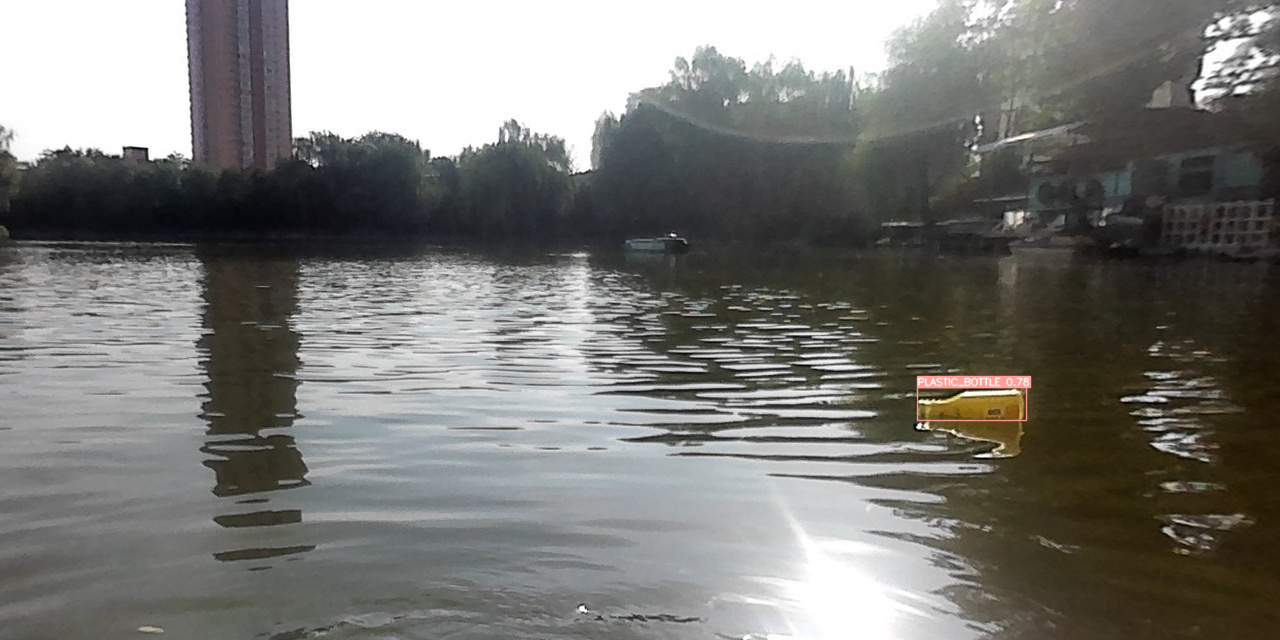

In [ ]:
pred_img